In [27]:
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cpu


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from fractions import Fraction
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter


In [29]:
# ------------- Config -------------
SEED          = 42
SIDE          = 96
TRAIN_SAMPLES = 12000
VAL_SAMPLES   = 2000
EPOCHS        = 15
BATCH_SIZE    = 64

LR            = 3e-4          # collapse 방지용 안정적인 lr
WEIGHT_DECAY  = 1e-5
RATIOS        = [(1,1),(1,2),(1,3),(2,3),(3,4)]  # 필요 비율만 남겨도 OK

# Augmentation (적당히 보수적)
THICKNESS_PX  = (1, 2)
GRID_PROB     = 0.3
NOISE_STD     = (0, 6)
ROT_JIT_DEG   = (-5, 5)
SCALE_JIT     = (0.96, 1.04)

In [30]:
# ---------------- Utils (revised) ----------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)

def delta_to_pi_fraction(delta_rad, max_den=180):
    r = float(delta_rad % (2*np.pi)) / np.pi
    frac = Fraction(r).limit_denominator(max_den)
    k, n = frac.numerator, frac.denominator
    if k==0: txt="0"
    elif n==1: txt=f"{k}π"
    else: txt=f"{k}π/{n}"
    return txt

def lissajous_points(a,b,delta,n=1500,tmax=2*np.pi):
    t = np.linspace(0, tmax, n)
    x = np.sin(a*t + delta); y = np.sin(b*t)
    return x, y

def draw_curve(size, a, b, delta, thickness=2, margin=0.06):
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)
    x, y = lissajous_points(a,b,delta)
    x = x / (np.max(np.abs(x))+1e-9)
    y = y / (np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    draw.line(list(zip(px, py)), fill=0, width=thickness, joint="curve")
    return img

def apply_random_pose(img):
    ang = random.uniform(*ROT_JIT_DEG)
    sx  = random.uniform(*SCALE_JIT)
    sy  = random.uniform(*SCALE_JIT)
    nx, ny = int(img.width*sx), int(img.height*sy)
    img2 = img.resize((nx, ny), resample=Image.BILINEAR)
    canvas = Image.new('L', img.size, 255)
    ox, oy = (canvas.width-img2.width)//2, (canvas.height-img2.height)//2
    canvas.paste(img2, (ox, oy))
    return canvas.rotate(ang, resample=Image.BILINEAR, fillcolor=255)

def overlay_grid(img):
    if random.random() > GRID_PROB: return img
    g = Image.new('L', img.size, 255); dr = ImageDraw.Draw(g)
    W, H = img.size; step = W//6; gray = 170
    for x in range(0, W, step): dr.line([(x,0),(x,H)], fill=gray, width=1)
    for y in range(0, H, step): dr.line([(0,y),(W,y)], fill=gray, width=1)
    return Image.blend(img, g, alpha=0.35)

def add_noise(img):
    arr = np.array(img).astype(np.float32)
    std = random.uniform(*NOISE_STD)
    if std>0: arr += np.random.normal(0, std, arr.shape)
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def preprocess_to_tensor(img):
    arr = np.array(img, dtype=np.float32)/255.0
    return torch.from_numpy(arr).unsqueeze(0)  # (1,H,W)


In [31]:
# ========================= Dataset (small-delta aware) =========================
class LissajousPhaseDataset(Dataset):
    def __init__(self, size=96, samples=1000, ratios=[(1,3)]):
        self.size    = size
        self.samples = samples
        self.ratios  = ratios

    def __len__(self): return self.samples

    def _sample_delta(self):
        # 절반은 전구간, 절반은 작은 위상/특정 구간 버킷에서 샘플링 → 분포 다양화
        if random.random() < 0.5:
            return np.random.uniform(0, 2*np.pi)
        else:
            # 작은 δ, 교차가 자주 생기는 구간 등을 섞어서
            buckets = [(0,30),(45,75),(150,210),(285,330)]
            lo,hi = random.choice(buckets)
            return np.deg2rad(np.random.uniform(lo,hi))

    def __getitem__(self, i):
        a,b    = random.choice(self.ratios)
        delta  = self._sample_delta()

        thickness = random.randint(*THICKNESS_PX)
        img = draw_curve(self.size, a, b, delta, thickness=thickness)
        img = apply_random_pose(img)
        img = overlay_grid(img)
        img = add_noise(img)

        x = preprocess_to_tensor(img)                       # (1,H,W)
        cond = torch.tensor([a/6.0, b/6.0], dtype=torch.float32)
        y = torch.tensor([math.cos(delta), math.sin(delta)], dtype=torch.float32)
        return x, cond, y

In [32]:
# ---------------- Model ----------------
class PhaseNet(nn.Module):
    def __init__(self, side=96):
        super().__init__()
        ch = 32
        self.backbone = nn.Sequential(
            nn.Conv2d(1,ch,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(ch,ch,3,1,1), nn.ReLU(inplace=True),
            nn.Conv2d(ch,2*ch,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(2*ch,2*ch,3,1,1), nn.ReLU(inplace=True),
            nn.Conv2d(2*ch,4*ch,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(4*ch,4*ch,3,1,1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)   # (B,4ch,1,1)
        )
        self.cond = nn.Sequential(
            nn.Linear(2,32), nn.ReLU(inplace=True),
            nn.Linear(32,32), nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
            nn.Linear(4*ch+32, 64), nn.ReLU(inplace=True),
            nn.Linear(64, 2)
        )

    def forward(self, x, cond):
        f = self.backbone(x).flatten(1)    # (B,4ch)
        c = self.cond(cond)                # (B,32)
        y = self.head(torch.cat([f,c], 1)) # (B,2)
        return F.normalize(y, dim=1)       # 항상 단위원


In [33]:
# ---------------- Loss & Train ----------------
def angular_loss(pred, target):
    # pred/target: (B,2) unit vectors
    cos_sim = (pred * target).sum(dim=1).clamp(-1,1)
    return (1.0 - cos_sim).mean()

def unit_circle_reg(pred):
    return ((pred.pow(2).sum(dim=1) - 1.0).pow(2)).mean()

def variance_spread_loss(pred):
    # 예측이 한 점에 몰리지 않도록 평균 분산을 '키우는' 항(마이너스 부호로 최대화)
    v = pred.var(dim=0, unbiased=False).mean()
    return -v

def _rbf(x, y, sigma=0.5):
    # x,y: (N,2) / (M,2)
    xx = (x**2).sum(1, keepdim=True)
    yy = (y**2).sum(1, keepdim=True)
    dist = xx + yy.T - 2*x@y.T
    return torch.exp(-dist / (2*sigma**2))

def mmd_rbf(x, y, sigma=0.5):
    kxx = _rbf(x,y=x, sigma=sigma)
    kyy = _rbf(y,y=y, sigma=sigma)
    kxy = _rbf(x,y,   sigma=sigma)
    return kxx.mean() + kyy.mean() - 2*kxy.mean()


In [40]:
set_seed()
full = LissajousPhaseDataset(size=SIDE, samples=TRAIN_SAMPLES+VAL_SAMPLES, ratios=RATIOS)
train_set, val_set = random_split(full, [TRAIN_SAMPLES, VAL_SAMPLES],
                                  generator=torch.Generator().manual_seed(SEED))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = PhaseNet(side=SIDE).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Loss weights (collapse 방지 세게 → 이후 안정되면 줄여가도 됨)
L_ANG = 1.0
L_UNIT = 0.02
L_VAR = 0.10    # ↓
L_MMD = 0.25    # ↓

best_val = 1e9
ckpt_path = "phase_cnn_best.pt"
print("Device:", device)

for ep in range(1, EPOCHS+1):
    # ---- Train ----
    model.train(); tr_loss=0; n=0
    for x,cond,y in train_loader:
        x,cond,y = x.to(device), cond.to(device), y.to(device)
        out = model(x,cond)
        out_n = F.normalize(out, dim=1)

        loss = (
            L_ANG  * angular_loss(out_n, y) +
            L_UNIT * unit_circle_reg(out_n) +
            L_VAR  * variance_spread_loss(out_n) +
            L_MMD  * mmd_rbf(out_n, y)
        )
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        tr_loss += loss.item()*x.size(0); n += x.size(0)
    tr = tr_loss/n

    # ---- Val ----
    model.eval(); tot=0; n=0; outs_all=[]
    with torch.no_grad():
        for x,cond,y in val_loader:
            x,cond,y = x.to(device), cond.to(device), y.to(device)
            out = model(x,cond)
            out_n = F.normalize(out, dim=1)
            val_loss = L_ANG*angular_loss(out_n,y)  # 검증은 핵심 항만
            tot += val_loss.item()*x.size(0); n+=x.size(0)
            outs_all.append(out_n.cpu())
    va = tot/n
    outs_all = torch.cat(outs_all,0)
    pred_var = outs_all.var(dim=0, unbiased=False).mean().item()

    print(f"[{ep:02d}] train={tr:.4f} | val={va:.4f} | pred_var={pred_var:.6e}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), ckpt_path)

print("✅ Saved best to:", ckpt_path)


Device: cuda
[01] train=1.0023 | val=0.8578 | pred_var=2.222489e-01
[02] train=0.9041 | val=0.8989 | pred_var=2.544261e-01
[03] train=0.9229 | val=0.8969 | pred_var=4.149020e-01
[04] train=0.8631 | val=0.8386 | pred_var=3.713691e-01
[05] train=0.8235 | val=0.7780 | pred_var=2.614794e-01
[06] train=0.7869 | val=0.8175 | pred_var=3.659426e-01
[07] train=0.7573 | val=0.7529 | pred_var=2.509681e-01
[08] train=0.7381 | val=0.7360 | pred_var=3.750458e-01
[09] train=0.7391 | val=0.7298 | pred_var=3.543959e-01
[10] train=0.7447 | val=0.7285 | pred_var=4.095953e-01
[11] train=0.7274 | val=0.7806 | pred_var=4.035718e-01
[12] train=0.7300 | val=0.7744 | pred_var=3.771000e-01
[13] train=0.7455 | val=0.7794 | pred_var=4.234538e-01
[14] train=0.7402 | val=0.7379 | pred_var=4.587542e-01
[15] train=0.7307 | val=0.7732 | pred_var=3.450882e-01
✅ Saved best to: phase_cnn_best.pt


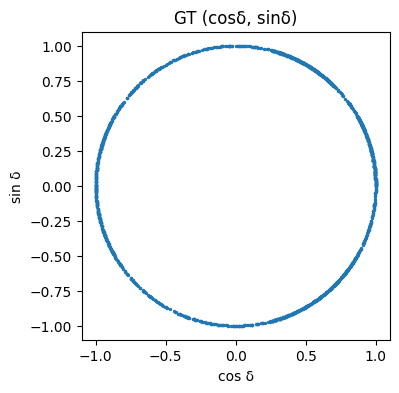

C:\Users\KOSJ\AppData\Local\Temp\ipykernel_20820\3152724393.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

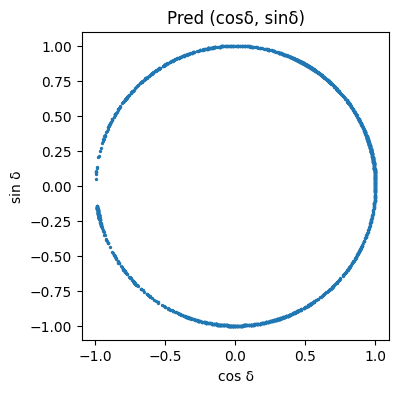

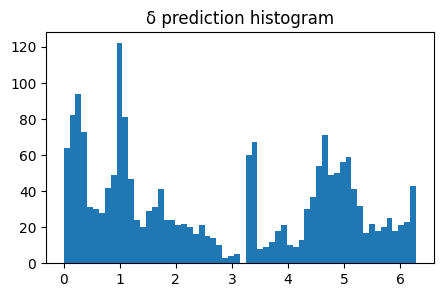

In [39]:
# ------------------------------- Diagnostics ------------------------------
# (선택) 검증 GT / 예측 산점도 & δ 히스토그램
def plot_val_scatter_and_hist():
    # GT
    ys=[]
    for _,_,y in val_loader: ys.append(y.numpy())
    ys=np.concatenate(ys,0)
    plt.figure(figsize=(4,4))
    plt.scatter(ys[:,0],ys[:,1],s=2); plt.gca().set_aspect('equal')
    plt.title("GT (cosδ, sinδ)"); plt.xlabel("cos δ"); plt.ylabel("sin δ"); plt.show()

    # Pred
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval(); outs=[]
    with torch.no_grad():
        for x,cond,_ in val_loader:
            v = F.normalize(model(x.to(device),cond.to(device)), dim=1).cpu().numpy()
            outs.append(v)
    outs=np.concatenate(outs,0)
    plt.figure(figsize=(4,4))
    plt.scatter(outs[:,0],outs[:,1],s=2); plt.gca().set_aspect('equal')
    plt.title("Pred (cosδ, sinδ)"); plt.xlabel("cos δ"); plt.ylabel("sin δ"); plt.show()

    pred_delta = np.mod(np.arctan2(outs[:,1], outs[:,0]), 2*np.pi)
    plt.figure(figsize=(5,3))
    plt.hist(pred_delta, bins=60); plt.title("δ prediction histogram"); plt.show()

plot_val_scatter_and_hist()  # 필요할 때 주석 해제1


→ index=540, ratio 1:3
GT   δ ≈ 223.41°  (211π/170)
PRED δ ≈ 18.75°  (5π/48)   |   SSIM≈0.2944


C:\Users\KOSJ\AppData\Local\Temp\ipykernel_20820\797256363.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=devi

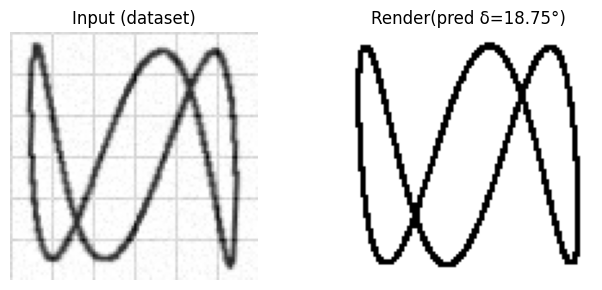

In [51]:

def _delta_to_pi_text(delta_rad, max_den=180):
    r = float(delta_rad % (2*np.pi)) / np.pi
    frac = Fraction(r).limit_denominator(max_den)
    k, n = frac.numerator, frac.denominator
    return ("0" if k==0 else (f"{k}π" if n==1 else f"{k}π/{n}"))

@torch.no_grad()
def show_random_prediction(ds, model, device, idx=None, side=SIDE, thickness=2):
    """
    ds: Dataset(예: val_set), model: 학습된 PhaseNet, device: 'cuda' or 'cpu'
    idx: None이면 무작위, 아니면 고정 인덱스
    """
    model.eval()
    if idx is None:
        idx = np.random.randint(len(ds))
    x, cond, y = ds[idx]                      # x:(1,H,W), cond:[a/6,b/6], y:[cosδ,sinδ]
    
    # (a,b) 복원
    a = int(round(float(cond[0]) * 6))
    b = int(round(float(cond[1]) * 6))
    
    # GT δ
    gt_delta = float(np.arctan2(float(y[1]), float(y[0])) % (2*np.pi))
    
    # 예측 δ
    v = model(x.unsqueeze(0).to(device), cond.unsqueeze(0).to(device)).cpu().numpy().reshape(2)
    pred_delta = float(np.arctan2(v[1], v[0]) % (2*np.pi))
    
    # 시각화용 이미지 준비
    img_in   = (x.numpy().squeeze() * 255).astype(np.uint8)
    img_pred = np.array(draw_curve(side, a, b, pred_delta, thickness=thickness))
    
    # SSIM(실험용 간단 스코어)
    ssim_val = ssim(img_in, img_pred, data_range=255)
    
    # 각도 표기(° / kπ/n)
    gt_deg   = float(np.degrees(gt_delta))
    pd_deg   = float(np.degrees(pred_delta))
    gt_pi    = _delta_to_pi_text(gt_delta)
    pd_pi    = _delta_to_pi_text(pred_delta)
    
    # 출력
    print(f"→ index={idx}, ratio {a}:{b}")
    print(f"GT   δ ≈ {gt_deg:.2f}°  ({gt_pi})")
    print(f"PRED δ ≈ {pd_deg:.2f}°  ({pd_pi})   |   SSIM≈{ssim_val:.4f}")
    
    fig, axes = plt.subplots(1,2, figsize=(7,3))
    axes[0].imshow(img_in, cmap='gray');  axes[0].set_title("Input (dataset)"); axes[0].axis('off')
    axes[1].imshow(img_pred, cmap='gray');axes[1].set_title(f"Render(pred δ={pd_deg:.2f}°)"); axes[1].axis('off')
    plt.tight_layout(); plt.show()

# 사용 예시(검증셋에서 무작위 1장)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
show_random_prediction(val_set, model, device)      # idx=정수 로 주면 고정

In [36]:
# -------------------------------- Inference --------------------------------
def predict_delta(model, img_gray_pil, a, b, side=SIDE, device=None):
    if device is None: device = next(model.parameters()).device
    img = img_gray_pil.convert('L').resize((side, side), Image.BILINEAR)
    x = preprocess_to_tensor(img).unsqueeze(0).to(device)
    cond = torch.tensor([[a/6.0,b/6.0]],dtype=torch.float32).to(device)
    with torch.no_grad():
        vec = F.normalize(model(x,cond), dim=1).cpu().numpy().reshape(2)
    delta = float(np.arctan2(vec[1], vec[0]) % (2*np.pi))
    return delta

In [37]:
# ================= Inference on YOUR experiment image =================
import os, numpy as np, matplotlib.pyplot as plt
from PIL import Image

# 1) 체크포인트 로드(학습이 끝난 뒤 실행)
if os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"✅ Loaded checkpoint: {ckpt_path}")
else:
    print(f"⚠️ Checkpoint not found: {ckpt_path}  (학습 셀을 먼저 실행하세요)")

# 2) (a:b) 비 입력
def parse_ratio(s):
    s = s.strip()
    if ":" in s:
        a,b = s.split(":")
    else:
        a,b = s.split()  # "1 3" 형태 허용
    return int(a), int(b)

ratio_str = input("각진동수 비를 입력하세요 (예: 1:3) : ")
a, b = parse_ratio(ratio_str)
print(f"→ ratio = {a}:{b}")

# 3) 이미지 업로드/불러오기 (Colab/로컬 둘 다 지원)
try:
    from google.colab import files
    print("➡️ 실험 이미지 1장 업로드(.png/.jpg)")
    uploaded = files.upload()
    fname = next(iter(uploaded))
except Exception:
    fname = input("이미지 경로를 입력하세요 (예: ./my_lissajous.png) : ").strip()

img_in = Image.open(fname)

# 4) 예측 (cos/sin → atan2 복원)
pred_delta_rad, viz = predict_delta(model, img_in, a, b, side=SIDE, device=device)
pred_delta_deg = float(np.degrees(pred_delta_rad))
pi_txt = delta_to_pi_fraction(pred_delta_rad, max_den=180)

print("\n===== Prediction on your image =====")
print(f"ratio {a}:{b}")
print(f"δ ≈ {pred_delta_deg:.2f}°  ({pi_txt})   |   rad = {pred_delta_rad:.6f}")

# 5) 시각화: 입력(리사이즈) vs 예측 δ로 렌더
from PIL import ImageDraw
def draw_curve_quick(size, a, b, delta, thickness=2, margin=0.06):
    # 기존 draw_curve와 동일하지만 의존 최소화를 위해 재사용
    from math import sin
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)
    t = np.linspace(0, 2*np.pi, 1500)
    x = np.sin(a*t + delta); y = np.sin(b*t)
    x = x/(np.max(np.abs(x))+1e-9); y = y/(np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    draw.line(list(zip(px, py)), fill=0, width=thickness, joint="curve")
    return img

img_fit = draw_curve_quick(SIDE, a, b, pred_delta_rad, thickness=2)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(viz.convert('L').resize((SIDE,SIDE)), cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_fit, cmap='gray'); plt.title(f"Render @ δ={pred_delta_deg:.2f}° ({pi_txt})"); plt.axis('off')
plt.tight_layout(); plt.show()


✅ Loaded checkpoint: phase_cnn_best.pt


C:\Users\KOSJ\AppData\Local\Temp\ipykernel_20820\1182857570.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=devi

→ ratio = 1:3


TypeError: cannot unpack non-iterable float object